In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

#load all real users and {num_syn} synthetic users trajectory data of viewing of {frame_range} specified from video {video_numbe} 
def groupby_frame_no(video_number, frame_range,num_syn, pixel=False):
    
    X = "X"
    Y = "Y"
    if pixel:
        X= "X_pixel"
        Y = "Y_pixel"
    # Initialize an empty dataframe to store the combined data
    combined_data_1 = pd.DataFrame(columns=['Frame.No'])  
    
    # Iterate over user numbers for the first set of data
    for user_num in range(1, 49):
        csv_path = f"Exp1/{user_num}/video_{video_number}-projection-pre-mov.csv"
        user_data = pd.read_csv(csv_path)
        user_data = user_data[(user_data['Frame.No'] >= frame_range[0]) & (user_data['Frame.No'] <= frame_range[1])]
        user_data[X] = user_data[X] - 0.25
        # Filter data based on frame_range and keep only 'Frame.No', 'X', and 'Y' columns
        filtered_data = user_data[['Frame.No', X, Y]]
        # Rename X and Y columns with user number
        filtered_data = filtered_data.rename(columns={X: f'User{user_num}_X', Y: f'User{user_num}_Y'})
        
        # Merge filtered data with combined data on 'Frame.No'
        combined_data_1 = pd.merge(combined_data_1, filtered_data, on='Frame.No', how='outer')
    
    combined_data_2 = pd.DataFrame(columns=['Frame.No'])

    # Iterate over user numbers for the second set of data
    for user_num in range(1, num_syn+1):
        csv_path = f"./Attemp_2/sal{video_number+1}-eml/00{video_number+1}-syn-u{user_num}.csv"
        user_data = pd.read_csv(csv_path)
        user_data = user_data[(user_data['Frame.No'] >= frame_range[0]) & (user_data['Frame.No'] <= frame_range[1])]
        user_data[X] = user_data[X] - 0.25
        filtered_data = user_data[['Frame.No', X,Y]]
       
        filtered_data = filtered_data.rename(columns={X: f'User{user_num}_X', Y: f'User{user_num}_Y'})
        
        # Merge filtered data with combined data on 'Frame.No'
        combined_data_2 = pd.merge(combined_data_2, filtered_data, on='Frame.No', how='outer')
  
    return combined_data_1, combined_data_2

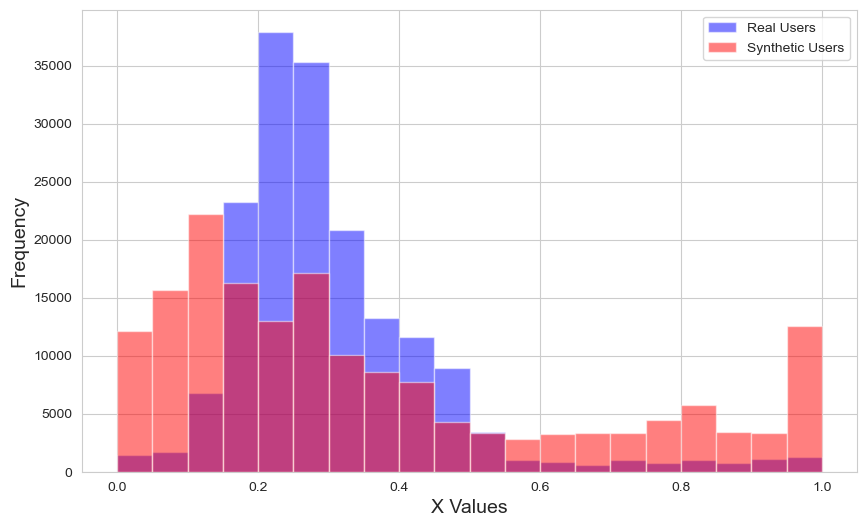

In [5]:
#Fig5-a Distribution of X-axis fixations in the video ”The Last of the Rhinos”

# Extract X values for all users (real and synthetic)
rdf9,sdf9 = groupby_frame_no(8, [1,3600],49)

real_X_values = rdf9[[f'User{i}_X' for i in range(1, 49)]].values.flatten()
synthetic_X_values = sdf9[[f'User{i}_X' for i in range(1, 49)]].values.flatten()

# Plot histograms
plt.figure(figsize=(10, 6))

plt.hist(real_X_values, bins=20, alpha=0.5, color='blue', label='Real Users')
plt.hist(synthetic_X_values, bins=20, alpha=0.5, color='red', label='Synthetic Users')

plt.xlabel('X Values',fontsize=14)
plt.ylabel('Frequency',fontsize=14)

plt.legend()

plt.show()


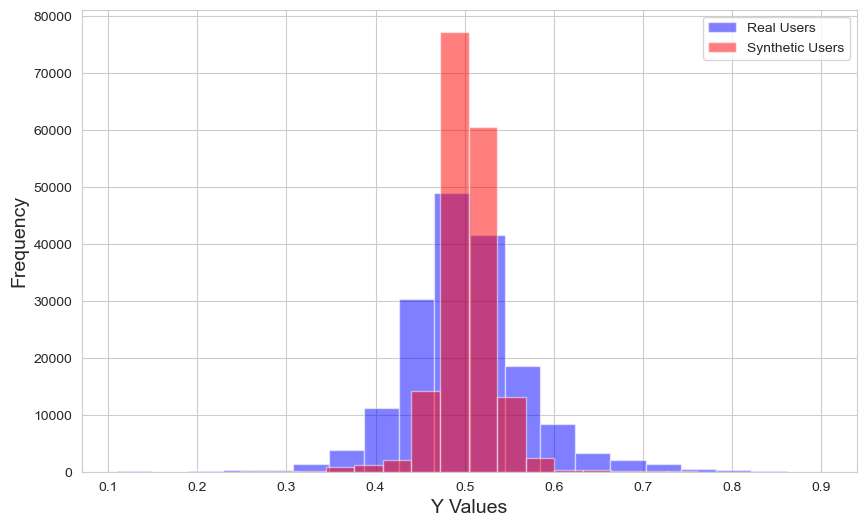

In [7]:
#Fig5-b Distribution of Y-axis fixations in the video ”The Last of the Rhinos”


real_X_values = rdf9[[f'User{i}_Y' for i in range(1, 49)]].values.flatten()
synthetic_X_values = sdf9[[f'User{i}_Y' for i in range(1, 49)]].values.flatten()


plt.figure(figsize=(10, 6))

plt.hist(real_X_values, bins=20, alpha=0.5, color='blue', label='Real Users')
plt.hist(synthetic_X_values, bins=20, alpha=0.5, color='red', label='Synthetic Users')

plt.xlabel('Y Values',fontsize=14)
plt.ylabel('Frequency',fontsize=14)

plt.legend()

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


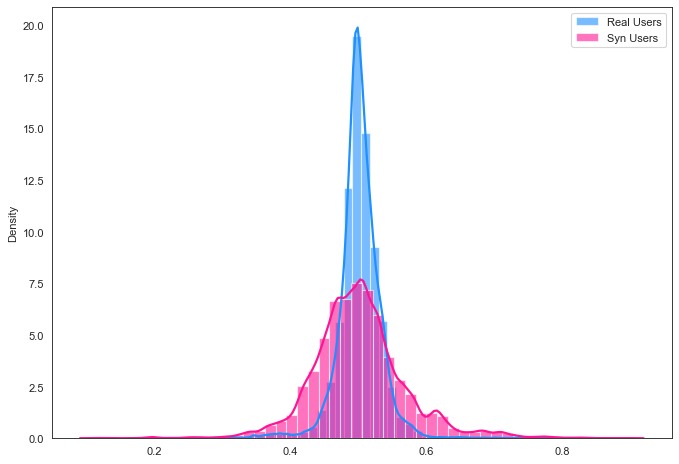

In [8]:
from scipy.stats import norm

import seaborn as sns
sns.set_style("white")


real_X_values = rdf9[[f'User{i}_Y' for i in range(1, 49)]].values.flatten()
synthetic_X_values = sdf9[[f'User{i}_Y' for i in range(1, 49)]].values.flatten()

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(synthetic_X_values, color="dodgerblue", label="Real Users", **kwargs)
sns.distplot(real_X_values, color="deeppink", label="Syn Users", **kwargs)

plt.legend()

In [9]:
def downsample_data(dataframe, downsample_window):
    """
    Downsamples the dataframe by taking the first value of 'Frame.No' column
    and averaging other columns for every 'downsample_window' rows.
    """
 
    frame_no_first_values = dataframe.groupby(dataframe.index // downsample_window)['Frame.No'].first()
    
    other_columns_mean = dataframe.groupby(dataframe.index // downsample_window).mean().iloc[:, 1:]
    
    downsampled_data = pd.concat([frame_no_first_values, other_columns_mean], axis=1)
    
    return downsampled_data

In [10]:
# calculate the displacement of a point on x-axis accounting for frame wrapping (because of the nature of frame as a shpere)
def distance(xc, xp):
  
    x1= xc
    x2 = xp

    dx = x2 - x1
   
    if x1 < x2:
        if 1.25 - x2 + (x1-0.25) < np.abs(x2 - x1):
            dx = ((1.25 - x2 + x1)) - 0.25
       
    elif x1 > x2:
        if 1.25 - x1 + (x2 - 0.25 ) < np.abs(x2 - x1):
            dx = (1.25 - x1 + x2) - 0.25 
   

    return np.abs(dx)

In [11]:
#calculate displacement through the video between each 2 consecutive frames
def calculate_mov(df,num_users=48):
    new_df = df.copy()  # Create a copy of the original DataFrame to store updated values
    
    for index, row in df.iterrows():
        for i in range(1, num_users+1):
            user_x_col = f'User{i}_X'
            user_y_col = f'User{i}_Y'
            if index == 0:
                new_df.at[index, user_y_col] = 0
                new_df.at[index, user_x_col] = 0
            else:
                new_df.at[index, user_y_col] = np.abs(row[user_y_col] - df.iloc[index - 1][user_y_col])
                new_df.at[index, user_x_col] = distance(row[user_x_col], df.iloc[index - 1][user_x_col])

    return new_df

In [32]:
#calculate mean and std for each user in usersmovements dataframe
def user_distribution_stats(df):
    user_columns = [col for col in df.columns if col.startswith('User')]
    user_x_columns = [col for col in user_columns if col.endswith('_X')]
    user_y_columns = [col for col in user_columns if col.endswith('_Y')]
 
    
    x_means = []
    x_stds = []
    y_means = []
    y_stds = []
    
    for user_x_col, user_y_col in zip(user_x_columns, user_y_columns):
        x_mean = df[user_x_col].mean()
        x_std = df[user_x_col].std()
        y_mean = df[user_y_col].mean()
        y_std = df[user_y_col].std()
        
        x_means.append(x_mean)
        x_stds.append(x_std)
        y_means.append(y_mean)
        y_stds.append(y_std)
        
    return {
        'X_means': x_means,
        'X_stds': x_stds,
        'Y_means': y_means,
        'Y_stds': y_stds
    }

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

df9_real , df9_syn = groupby_frame_no(8, [1,3600],48)
df7_real , df7_syn = groupby_frame_no(6, [1,3600],48)
df2_real , df2_syn = groupby_frame_no(1, [1,3600],48)

df9_real , df9_syn = downsample_data(df9_real,10),downsample_data(df9_syn,10)
df7_real , df7_syn = downsample_data(df7_real,10),downsample_data(df7_syn,10)
df2_real , df2_syn = downsample_data(df2_real,10),downsample_data(df2_syn,10)


df9_real , df9_syn = calculate_mov(df9_real),calculate_mov(df9_syn)
df7_real , df7_syn = calculate_mov(df7_real),calculate_mov(df7_syn)
df2_real , df2_syn = calculate_mov(df2_real),calculate_mov(df2_syn)

df9_real,df9_syn = user_distribution_stats(df9_real) ,user_distribution_stats(df9_syn)
df7_real,df7_syn = user_distribution_stats(df7_real) ,user_distribution_stats(df7_syn)
df2_real,df2_syn = user_distribution_stats(df2_real) ,user_distribution_stats(df2_syn)

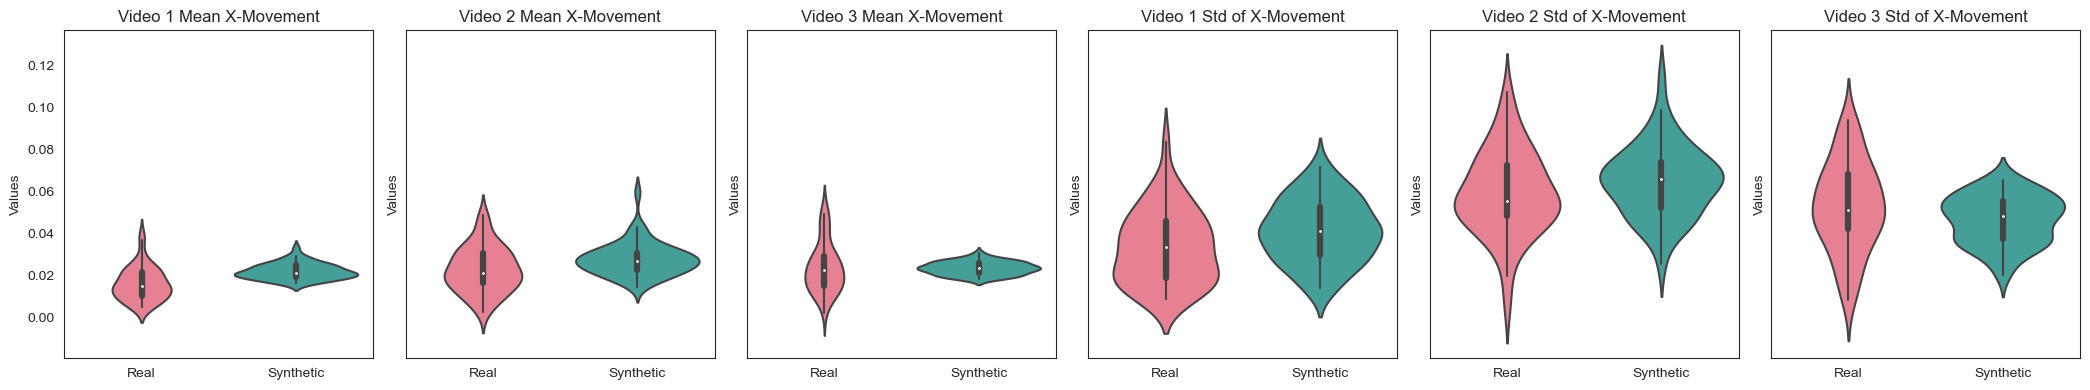

In [34]:
#Fig. 3 Comparison between real and synthetic users X-axis movement distribution using violin plot

data_video9 = pd.DataFrame({'Real': df9_real['X_means'], 'Synthetic': df9_syn['X_means']})
data_video7 = pd.DataFrame({'Real': df7_real['X_means'], 'Synthetic': df7_syn['X_means']})
data_video2 = pd.DataFrame({'Real': df2_real['X_means'], 'Synthetic': df2_syn['X_means']})
data_video9_std = pd.DataFrame({'Real': df9_real['X_stds'], 'Synthetic': df9_syn['X_stds']})
data_video7_std = pd.DataFrame({'Real': df7_real['X_stds'], 'Synthetic': df7_syn['X_stds']})
data_video2_std = pd.DataFrame({'Real': df2_real['X_stds'], 'Synthetic': df2_syn['X_stds']})

all_data = [data_video9, data_video7, data_video2, data_video9_std, data_video7_std, data_video2_std]
titles = ['Video 1 Mean X-Movement', 'Video 2 Mean X-Movement', 'Video 3 Mean X-Movement', 'Video 1 Std of X-Movement', 'Video 2 Std of X-Movement', 'Video 3 Std of X-Movement']

fig, axes = plt.subplots(1, 6, figsize=(21, 4), sharey='row')  # 1 row, 6 columns

for i, (data, title) in enumerate(zip(all_data, titles)):
    sns.violinplot(data=data, ax=axes[i], palette='husl')
    axes[i].set_title(title)
    axes[i].set_ylabel('Values')

plt.tight_layout()
plt.show()

In [30]:
#2560 here is the frame width, 6 number of tiles
def get_tile(x):
    tile_width = int(2560 / 6 )
    tile = (x.values //  tile_width) + 1
    
    return tile

df9_real , df9_syn = groupby_frame_no(8, [1,3600],49,pixel=True)
#map fixation coordinates to tile number (1 based indexing)
df9_real[[col for col in df9_real.columns if col != 'Frame.No']] = df9_real[[col for col in df9_real.columns if col != 'Frame.No']].apply(get_tile)
df9_syn[[col for col in df9_syn.columns if col != 'Frame.No']] = df9_syn[[col for col in df9_syn.columns if col != 'Frame.No']].apply(get_tile)
# Dropping vertical columns
columns_to_drop = [col for col in df9_real.columns if 'Y' in col]
df9_real = df9_real.drop(columns=columns_to_drop)

columns_to_drop = [col for col in df9_syn.columns if 'Y' in col]
df9_syn = df9_syn.drop(columns=columns_to_drop)


# calculate  frequencies of fixations in each horizontal tile 
# Fig. 4
def get_horizontal_tiles_fixations_freq(df, num_tiles=6,num_users=48):
    output_df = pd.DataFrame(columns=['Frame.No'] + [f'T{j}' for j in range(1, num_tiles + 1)])
    for j in range(1, num_tiles+1):
        t_col_name = f'T{j}'
        count_list = []
        for frame_no in range(1, df["Frame.No"].max() +1):
            count = sum(df[f'User{i}_X'].iloc[frame_no - 1] == j for i in range(1, num_users+1)) / num_users
            count_list.append(count)
        output_df[t_col_name] = count_list

    output_df["Frame.No"] = df["Frame.No"]
    return output_df

In [26]:
df9_real = df9_real.astype(int)
df9_syn = df9_syn.astype(int)

freq_real = get_horizontal_tiles_fixations_freq(df9_real, 6,48)
freq_syn = get_horizontal_tiles_fixations_freq(df9_syn, 6,48)

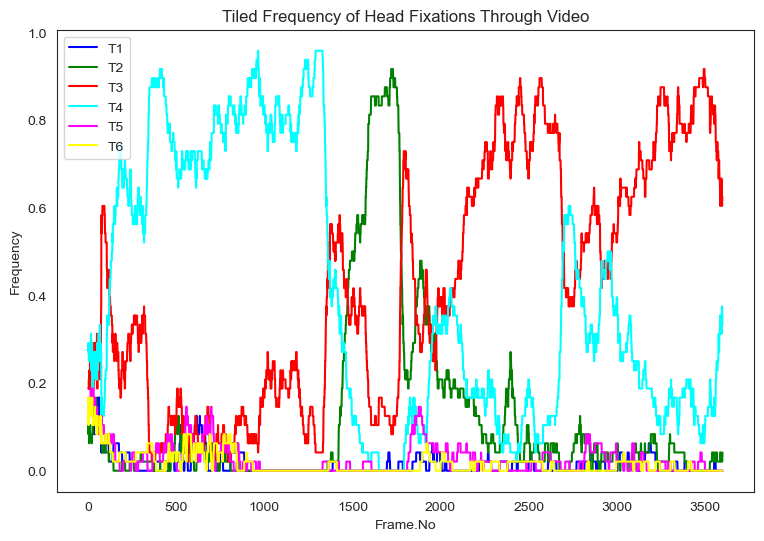

In [28]:
# # Fig.4-a Tiled frequency of head fixations throughout ’The Last of the Rhinos’ video for real users 

# Create a list of colors for each tile curve
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange']
num_of_tiles = 6
plt.figure(figsize=(9, 6))  
for i in range(1, num_of_tiles + 1): 
    plt.plot(freq_real['Frame.No'],freq_real[f'T{i}'], color=colors[i-1], label=f'T{i}')

plt.xlabel('Frame.No')
plt.ylabel('Frequency')
plt.title('Tiled Frequency of Head Fixations Through Video')
plt.legend()

plt.show()

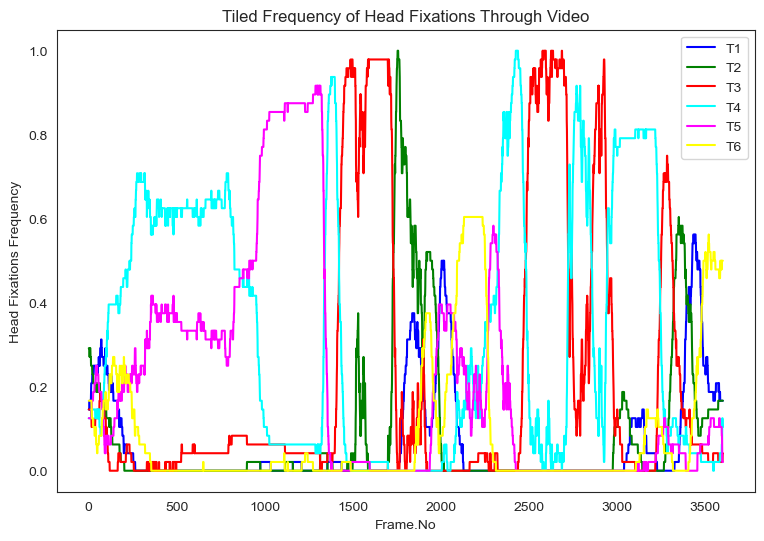

In [29]:
#  Fig.4-a Tiled frequency of head fixations throughout ’The Last of the Rhinos’ video for synthetic users 


plt.figure(figsize=(9, 6))  # Adjust the figsize as needed
for i in range(1, num_of_tiles + 1):  # Assuming num_of_tiles is the number of tiles
    plt.plot(freq_syn['Frame.No'],freq_syn[f'T{i}'], color=colors[i-1], label=f'T{i}')

plt.xlabel('Frame.No')
plt.ylabel('Head Fixations Frequency')
plt.title('Tiled Frequency of Head Fixations Through Video')
plt.legend()

# Show plot
plt.show()